# Step 4 (Spark GraphX)

## Environment Setup

### Install requirements

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.6.tgz
!tar xf spark-2.4.8-bin-hadoop2.6.tgz
!pip -q install findspark graphframes

### Set environment variables

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.6"

os.environ["HADOOP_HOME"] = os.environ["SPARK_HOME"]
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.0-spark2.4-s_2.11 pyspark-shell"

### Import libraries

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

In [4]:
from google.colab import drive

from graphframes import *

### Mount drive for log file

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get spark context

In [25]:
sc = spark.sparkContext

## Part 1

### Read vertex and edges file

In [6]:
vertex_file_path = '/content/drive/MyDrive/BD Graph/Vertex.txt'
with open(vertex_file_path) as vertex_file:
    vertices = [(id, title) for id, title in (line.strip().split('\t') for line in vertex_file)]
    vertex_file.close()

edges_file_path = '/content/drive/MyDrive/BD Graph/edges.txt'
with open(edges_file_path) as edges_file:
    edges = [(src, dst) for src, dst in (line.strip().split('\t') for line in edges_file)]
    edges_file.close()

### Create graph

In [7]:
vertices_data = spark.createDataFrame(vertices, ["id", "title"])
print("Vertices Schema:")
vertices_data.printSchema()

edges_data = spark.createDataFrame(edges, ["src", "dst"])
print("Edges Schema:")
edges_data.printSchema()

wiki_graph = GraphFrame(vertices_data, edges_data)

Vertices Schema:
root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)

Edges Schema:
root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)



### Show graph vertices and edges

In [8]:
wiki_graph.vertices.show()
wiki_graph.edges.show()

+-------------------+--------------------+
|                 id|               title|
+-------------------+--------------------+
|8774773382640701231|List of Canadian ...|
|7761101435592530731|List of Football ...|
|8133629125642450577|Template:2004 Foo...|
|7698287352205296646|File:North Melbou...|
|2097725138520422255|Georgia Football ...|
|6922631041164063688|Football at the 2...|
|1197038737428485418|Wikipedia:Miscell...|
|2558316557265591251|Football at the 2...|
|1775630591844818068|Serbian Football ...|
|4205664098526595262|Wikipedia:WikiPro...|
|1033687574081081174|1943–44 Netherlan...|
|6862802626977892137|1948–49 Football ...|
|3681282860489534792|1998–99 North Wes...|
|8747320282862100730|1984–85 Football ...|
|7895242920481704787|Template:1976–77 ...|
|4200215839332270980|Black Thunder Rug...|
| 687511193117412416|2008 UEFA Europea...|
|6058169767624236103|Template:College ...|
|1244764815707993800|Template:1976–77 ...|
|5775454784407389519|Football at the 2...|
+----------

## Part 2

### Max in degree in graph

In [17]:
print("Sorted in degrees:")
sorted_in_degree = wiki_graph.inDegrees.sort("inDegree", ascending=False)
sorted_in_degree.show()

print("Highest in degree:")
most_in_degree = sorted_in_degree.limit(1)
most_in_degree.show()
most_in_degree_vertex = (wiki_graph.vertices
                         .filter(f"id == {most_in_degree.collect()[0].id}"))
most_in_degree_vertex.show()

Sorted in degrees:
+-------------------+--------+
|                 id|inDegree|
+-------------------+--------+
| 946065507707541358|     327|
|3856212023725725593|     322|
|8978262722425160811|     316|
|6245498229508734555|     185|
|7264519433548233535|     180|
|5362090331808156011|     179|
| 277710621679830671|     149|
|1984578398767042266|     145|
|2395551540800395672|     134|
|5395033957924805072|     130|
|4254821691068011447|     119|
|7050959159375889025|     116|
|3282427710539568335|     115|
|4512002392249809415|     115|
|4254821691068016541|     113|
|4254821691068027845|     107|
|6623304200448015171|     105|
|2625575280669536231|     104|
|6908101889982380382|     102|
| 330493081995023431|     102|
+-------------------+--------+
only showing top 20 rows

Highest in degree:
+------------------+--------+
|                id|inDegree|
+------------------+--------+
|946065507707541358|     327|
+------------------+--------+

+------------------+-------------------+


### Max out degree in graph

In [21]:
print("Sorted in degrees:")
sorted_out_degree = wiki_graph.outDegrees.sort("outDegree", ascending=False)
sorted_out_degree.show()

print("Highest out degree:")
most_out_degree = sorted_out_degree.limit(1)
most_out_degree.show()
most_out_degree_vertex = (wiki_graph.vertices
                         .filter(f"id == {most_out_degree.collect()[0].id}"))
most_out_degree_vertex.show()
print("Title: {}".format(most_out_degree_vertex.collect()[0].title))

Sorted in degrees:
+-------------------+---------+
|                 id|outDegree|
+-------------------+---------+
|3841755165517709241|      264|
|4768697715794291382|      167|
| 946065507707541358|      141|
|1984578398767042266|      132|
|1749892575156253660|      130|
|8005203204779397051|      126|
|3794347177295221142|      125|
|5686723817617940514|      124|
|7927626332375316361|      116|
| 472311543090593619|      114|
|6245498229508734555|      110|
|5005974931152269142|       97|
|4884850602875197735|       93|
|3282427710539568335|       92|
|7829120379339412244|       88|
|7606187671156652264|       84|
|8473325610216524301|       80|
|6613148896255681939|       78|
|7167801971510974146|       77|
|8050287096245126179|       72|
+-------------------+---------+
only showing top 20 rows

Highest out degree:
+-------------------+---------+
|                 id|outDegree|
+-------------------+---------+
|3841755165517709241|      264|
+-------------------+---------+

+-----

## Part 3

### See overview of connected components

In [26]:
sc.setCheckpointDir('graphframes_cps')
wiki_graph.connectedComponents().show()

+-------------------+--------------------+-------------+
|                 id|               title|    component|
+-------------------+--------------------+-------------+
|8774773382640701231|List of Canadian ...|            1|
|7761101435592530731|List of Football ...|            1|
|8133629125642450577|Template:2004 Foo...|            1|
|7698287352205296646|File:North Melbou...|            1|
|2097725138520422255|Georgia Football ...| 103079215111|
|6922631041164063688|Football at the 2...|            1|
|1197038737428485418|Wikipedia:Miscell...| 137438953474|
|2558316557265591251|Football at the 2...|            1|
|1775630591844818068|Serbian Football ...|            1|
|4205664098526595262|Wikipedia:WikiPro...|            1|
|1033687574081081174|1943–44 Netherlan...|   8589934631|
|6862802626977892137|1948–49 Football ...|            1|
|3681282860489534792|1998–99 North Wes...|            1|
|8747320282862100730|1984–85 Football ...|            1|
|7895242920481704787|Template:1

### Calculate size of connected components

In [28]:
connected_components_size = (wiki_graph
                             .connectedComponents()
                             .groupBy('component')
                             .count()
                             .cache())
print("Connected components size:")
connected_components_size.show()

Connected components size:
+-------------+-----+
|    component|count|
+-------------+-----+
| 412316860436|    1|
| 146028888066|    1|
| 146028888086|    1|
|1468878815268|    1|
|1614907703302|    1|
| 377957122049|    1|
| 884763263008|    1|
| 429496729640|    1|
| 936302870530|    1|
|1228360646673|    1|
|1511828488192|    1|
|1666447310862|    1|
| 506806140928|    1|
| 266287972355|    1|
|1382979469334|    1|
| 644245094425|    1|
|  51539607590|    1|
|1005022347287|    1|
| 223338299414|    1|
|  17179869191|    1|
+-------------+-----+
only showing top 20 rows



#### Showing biggest connect components

In [36]:
connected_components_size.sort('count', ascending=False).show()

+-------------+-----+
|    component|count|
+-------------+-----+
|            1| 6477|
|  42949672979|   52|
|  85899345921|   35|
|   8589934631|   14|
| 163208757270|   14|
| 317827579922|   13|
|  77309411351|   13|
|  68719476736|   12|
|  68719476765|   11|
|  34359738381|    9|
| 154618822695|    7|
|  17179869223|    7|
| 687194767374|    6|
| 137438953508|    6|
| 292057776177|    6|
| 420906795013|    6|
| 146028888100|    6|
| 446676598817|    6|
| 730144440335|    5|
|1108101562411|    5|
+-------------+-----+
only showing top 20 rows



### Part 4

### Join in degrees with vertices data

In [32]:
vertices_full = wiki_graph.vertices.join(wiki_graph.inDegrees, 'id').cache()
print("Vertices data with in degrees:")
vertices_full.show()

Vertices data with in degrees:
+-------------------+--------------------+--------+
|                 id|               title|inDegree|
+-------------------+--------------------+--------+
|1266831434364880157|National Football...|       6|
|1331972860880417523|2010 United Footb...|       2|
|1369498455317078482|1938–39 Southern ...|       2|
|2000467072865855339|Football at the 1...|       2|
|2408272437532239374|1962 College Foot...|       3|
|2715722278057256350|Irish Football As...|      34|
|3451104515148607245|2009 Adelaide Foo...|       2|
|3502541721868043443|2005 Atlantic Ind...|       2|
|3920820843608643779|1990 UEFA Europea...|       5|
|4441168192505953100|Scotch Old Colleg...|       1|
|4499334646599551727|1943 College Foot...|       3|
|4680877142281628492|Football at the 2...|       2|
|4976384618951573351|Football at the 2...|       4|
|5423138579624850276|Devon County Foot...|       1|
|5433576273465536249|Highett Football ...|       1|
| 585583653337377412|1968–69 West

### Find top 10 articles

In [34]:
top_10_articles = (vertices_full
                   .sort('inDegree', ascending=False)
                   .limit(10))
print("Top 10 articles:")
top_10_articles.show()
print("Full titles:")
print([article.title for article in top_10_articles.collect()])

Top 10 articles:
+-------------------+--------------------+--------+
|                 id|               title|inDegree|
+-------------------+--------------------+--------+
| 946065507707541358| The Football League|     327|
|3856212023725725593|National Football...|     322|
|8978262722425160811|Australian Footba...|     316|
|6245498229508734555|Southern Football...|     185|
|7264519433548233535|Football League F...|     180|
|5362090331808156011|Football League S...|     179|
| 277710621679830671|All-Ireland Senio...|     149|
|1984578398767042266|Scottish Football...|     145|
|2395551540800395672|Football League T...|     134|
|5395033957924805072|Pro Football Hall...|     130|
+-------------------+--------------------+--------+

Full titles:
['The Football League', 'National Football League', 'Australian Football League', 'Southern Football League', 'Football League First Division', 'Football League Second Division', 'All-Ireland Senior Football Championship', 'Scottish Football

### Part 5

### Install requirements

In [49]:
!pip3 install -q networkx dimcli pyvis

     |████████████████████████████████| 327kB 32.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 


In [51]:
import networkx as nx
wiki = nx.from_pandas_edgelist(wiki_graph.edges.toPandas(), source='src', target='dst')

In [52]:
from dimcli.utils.networkviz import NetworkViz
viznet = NetworkViz(notebook=True, width="100%", height="800px")
viznet.from_nx(wiki)
viznet.show('wiki.html')

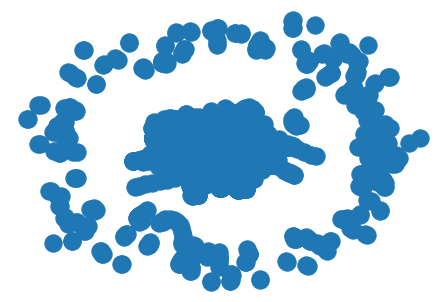

In [48]:
nx.draw(g)